# Joint $\ell_{2,1}$-norm minimization
$$\min_W\quad\frac12\|X - WD\|_F^2 + \alpha\|W\|_{2,1}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Bad key "backend in file /Users/masui/.matplotlib/matplotlibrc, line 1 ('"backend : Tkagg"')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution


## Toy data

In [2]:
np.random.seed(0)
n_samples = 60
n_features = 30
n_components = 50
transform_n_nonzero_coefs = 5

dictionary = np.random.randn(n_components, n_features)
W = np.random.rand(n_samples, n_components) * 2 - 1
for i in range(n_components - transform_n_nonzero_coefs):
    W[:, -(i+1)] = 0
X = W @ dictionary + np.random.randn(n_samples, n_features) * 0.1

$$X \simeq W D$$

## Efficient and robust feature selection via joint ℓ2, 1-norms minimization
[Nie, F., Huang, H., Cai, X., & Ding, C. H. (2010). Efficient and robust feature selection via joint ℓ2, 1-norms minimization. In Advances in neural information processing systems (pp. 1813-1821).](https://papers.nips.cc/paper/3988-efficient-and-robust-feature-selection-via-joint-l21-norms-minimization.pdf)

In [3]:
def sparse_code_via_l21(X, dictionary, alpha=1.0, max_iter=30):
    m, n = dictionary.shape
    A = np.vstack((dictionary, alpha * np.identity(n)))
    D_inv = np.identity(m+n)
    for _ in range(max_iter):
        DA = D_inv @ A
        ADA = np.linalg.inv(A.T @ DA)
        U = X @ ADA @ DA.T
        D_inv = 2 * np.diag(np.linalg.norm(U, axis=0))
    return U[:, :m]

In [4]:
%time coef1 = sparse_code_via_l21(X, dictionary, alpha=.1)

CPU times: user 20.3 ms, sys: 7.35 ms, total: 27.6 ms
Wall time: 7.8 ms


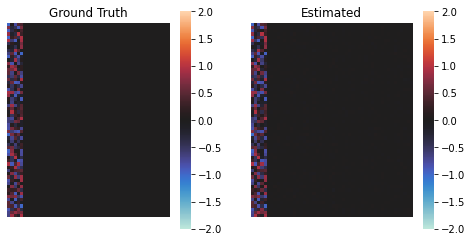

In [5]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.heatmap(W, xticklabels=False, yticklabels=False, annot=False, square=True, vmin=-2, vmax=2, center=0)
plt.title('Ground Truth')
plt.subplot(1, 2, 2)
sns.heatmap(coef1, xticklabels=False, yticklabels=False, annot=False, square=True, vmin=-2, vmax=2, center=0)
plt.title('Estimated')
plt.show()

## ADMM
\begin{align}
    \min_{W, Y} &\quad \frac1{2N}\|X - WD\|_F^2 + \alpha \sum_i\|y_i\|_2\\
    \text{s.t.} &\quad W - Y = 0
\end{align}

Augmented Lagrangian Function:
\begin{align}
    \mathcal{L}(W, Y, U) = \frac1{2N}\left\|X - WD\right\|_F^2 + \alpha \sum_i\|y_i\|_2 + U^\top(W - Y) + \frac\tau2\|W - Y\|_F^2
\end{align}

Optimal Condition:
\begin{align}
    \frac{\partial \mathcal{L}}{\partial W} = \frac1N(WD - X)D^\top + U + \tau(W - Y) = 0
\end{align}

\begin{align}
    \partial_{y_i} \mathcal{L} = \alpha\partial \|y_i\|_2 + u_i + \tau(y_i - w_i) \ni 0
\end{align}

ADMM Algorithm:
\begin{align}
    W^{t+1} &= \left(\frac1NXD^\top + \tau Y^{t} - U^{t}\right)\left(\frac1NDD^\top + \tau I\right)^{-1}\\
    y_i^{t+1} &= S\left(w_i^{t+1} + \frac1\tau u_i^t, \frac{\alpha}{\tau}\right)\\
    U^{t+1} &= U^t + \tau\left(W^{t+1} - Y^{t+1}\right)
\end{align}

where the shrinkage mapping $S$ is defined:
\begin{align}
    S(x, \alpha) = \max\left\{1 - \frac{\alpha}{\|x\|_2}, 0\right\}x
\end{align}

In [6]:
import sys
sys.path = ['..'] + sys.path
from spmimage.decomposition import sparse_encode_with_l21_norm

%time coef2 = sparse_encode_with_l21_norm(X, dictionary, alpha=.1)

CPU times: user 6.86 ms, sys: 817 µs, total: 7.67 ms
Wall time: 2.17 ms


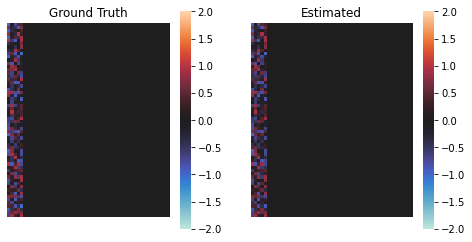

In [7]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.heatmap(W, xticklabels=False, yticklabels=False, annot=False, square=True, vmin=-2, vmax=2, center=0)
plt.title('Ground Truth')
plt.subplot(1, 2, 2)
sns.heatmap(coef2, xticklabels=False, yticklabels=False, annot=False, square=True, vmin=-2, vmax=2, center=0)
plt.title('Estimated')
plt.show()